In [1]:
from src.exp_helper import *

In [2]:
from src.model.bsln_kde import KDE
from src.model.bsln_bower import Bower

In [3]:
grid_size=50

In [4]:
train_tw = 60
verbose=1

In [5]:
d_bower = CompileData(spu_name='grid_%d' % grid_size)
d_bower.set_x(['crime'], category_groups={'crime':[['burglary']]}, by_category=False)
d_bower.set_y('crime/burglary')

****WARNING**** Some data get 0 assignment
****WARNING**** Some data get 0 assignment


In [6]:
grid_centers = d_bower.spu.Cen_coords.apply(lambda x: eval(x))

In [21]:

tr_bower_2 = Rolling(rsd='2016-05-01', red='2016-07-02', rstep=2, tw_past=train_tw, tw_pred=2)
er_bower_2 = Rolling(rsd='2016-08-01', red='2016-12-31', rstep=2, tw_past=train_tw, tw_pred=2)

In [8]:
x,y = data_for_fit(d_bower,'time_indexed_points', 'event_cnt', roller=tr_bower_2)

In [9]:
# bower = Bower(grid_size, bw=400, tw=train_tw, verbose=verbose)
# print(bower)

# bower.fit(x)

# pred = bower.pred(grid_centers)

In [10]:
kde400 = KDE(bw=400, tw=train_tw, verbose=verbose)
print(kde400)

KDE(bandwidth=400, timewindow=60, verbose=1)


In [11]:

from src.utils.metric_single_num import metrics

In [25]:

def evaluate_kde(compile_data, train_roller, eval_roller, model, evaluators, refit=False, keep_pred=False,
             x_setting='time_indexed_points', y_setting='event_cnt', verbose=0, debug=False):
    grid_centers = compile_data.spu.Cen_coords.apply(lambda x: eval(x))
    
    eval_res = []
    tmp_train_roller = copy.copy(train_roller)
    pred_res = None if not keep_pred else defaultdict(dict)
    
    for i, dates in enumerate(eval_roller.roll()):
        past_sd, past_ed, pred_sd, pred_ed = dates
        period = 'X: %s~%s -> Y: %s~%s' % (past_sd, past_ed, pred_sd, pred_ed)
        res = {'period': period}
        
        if refit:
            if verbose>1:
                print('refitting for evaluate period:', period)
            tmp_train_roller.red = past_sd
            X, Y = data_for_fit(compile_data, roller=tmp_train_roller, x_setting=x_setting, y_setting=y_setting,
                                stack_roll=False, verbose=verbose)
            model.fit(X, Y)
            if verbose>1:
                print('model fit')
                
        eval_x, eval_y = data_for_fit(compile_data, x_setting=x_setting, y_setting=y_setting, dates=dates,
                                      verbose=verbose)
        if verbose>1:
            print('predicting for each grid_center')
        pred_y = model.predict(grid_centers)
        
        if keep_pred:
            pred_res[period]['pred_y'] = pred_y
            pred_res[period]['true_y'] = eval_y
            
            
        if verbose>1:
            print('computing metrics')
        for e in evaluators:
            res[e.__name__] = e(eval_y, pred_y, compile_data.spu)
        eval_res.append(res)

        if i > 3 and debug:
            break
    eval_res = pd.DataFrame(eval_res)
    eval_res.set_index('period', inplace=True)
    return eval_res, pd.DataFrame.from_dict(pred_res, 'index')

In [20]:
eval_res, pred_res = evaluate_kde(d_bower, tr_bower_2, er_bower_2, kde400, metrics, refit=True, keep_pred=True, 
         x_setting='time_indexed_points', y_setting='event_cnt', debug=True, verbose=2)

refitting for evaluate period: X: 2016-08-01 00:00:00~2016-09-29 23:59:59 -> Y: 2016-09-30 00:00:00~2016-10-01 23:59:59
data setting:
	- y: event_cnt
	- x: time_indexed_points
	- tw_past: 2016-05-29 00:00:00 ~ 2016-07-27 23:59:59
	- tw_pred: 2016-07-28 00:00:00 ~ 2016-07-29 23:59:59
	- The last roll slice
	- Rolling:
		- rstep: 2
		- rsd: 2016-05-01 00:00:00
		- red: 2016-08-01 00:00:00
		- rnd: None
		- rback: False
		- num_step: inf
		- tw_past: 60
		- tw_pred: 2
coords is a dictionary, len==1, keep its value only
last_date = 2016-07-27 23:59:59
model fit
data setting:
	- y: event_cnt
	- x: time_indexed_points
	- tw_past: 2016-08-01 00:00:00 ~ 2016-09-29 23:59:59
	- tw_pred: 2016-09-30 00:00:00 ~ 2016-10-01 23:59:59
predicting for each grid_center
storing results


In [22]:
eval_res

,area_to_perimeter_ratio_upct_auc,hit_rate_upct_auc,mae,period,prediction_accuracy_index_upct_auc,r2,rmse,search_efficient_rate_upct_auc
0,1131.512042,0.734091,0.000459,X: 2016-08-01 00:00:00~2016-09-29 23:59:59 -> ...,1.569253,-0.000459,0.021414,0.287828


In [26]:
a = pred_res['X: 2016-08-01 00:00:00~2016-09-29 23:59:59 -> Y: 2016-09-30 00:00:00~2016-10-01 23:59:59']

In [33]:
df = pd.DataFrame([a['pred_y'], a['true_y']], index=['pred_y', 'true_y']).T

In [35]:
%matplotlib inline

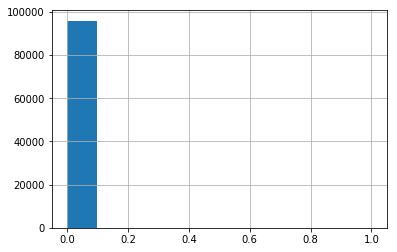

In [46]:
(df/df.max()).true_y.hist()

In [45]:
pd.DataFrame((df/df.max()).sort_values('true_y', ascending=False).values)

,0,1
0,0.567412,1.0
1,0.212446,1.0
2,0.273511,1.0
3,0.426026,1.0
4,0.314956,1.0
5,0.126470,1.0
6,0.187859,1.0
7,0.322133,1.0
8,0.431491,1.0
9,0.225414,1.0
